# TP - Recalage d'images

Nous allons tout d'abord lancer les imports classiques, vous remarquerez qu'il y a un fichier python qui s'appelle 'Recalage.py' et qui contient quelques routines.

In [317]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
from scipy import signal
from scipy import interpolate
import PIL 
import matplotlib.pyplot as plt
import Recalage as lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

Nous commençons par charger deux images synthétisées `f` et `g` qui sont essentiellement translatées l'une de l'autre.

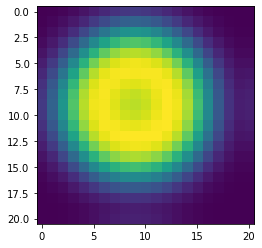

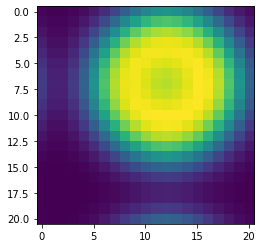

In [318]:
f,g,(X,Y)=lib.getGaussians()
plt.imshow(f)
plt.show()
plt.imshow(g)

On peut aussi visualiser les fonctions avec les commandes suivantes

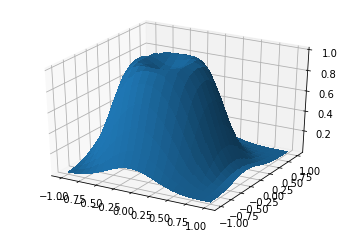

In [319]:
f,g,(X,Y)=lib.getGaussians()
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, f,
                       linewidth=0, antialiased=False)
plt.show()

# 1. Formalisation du problème

 ## 1.1 Formalisme continu

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

> $(P_1)$ : 
> Etant donnés $f$ et $g$, trouver un champ de vecteurs $u = (u_1, u_2)$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$


Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

> $(P_2)$ : On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du bruit par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2}_{R_2(u)=\textrm{variations  de  volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
> $$(P)\qquad \min_{u} E(u)+R(u).$$

Q1. A l'aide d'un développement de Taylor, vérifier la formule suivante
$$E(u+h)=E(u)+\int_\Omega (\nabla E(u) , h) +o(h)$$
Avec 
$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

Ce champs de vecteur $\nabla E(u)$ est le gradient de $E$.

# 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathbb{R}^n\times \mathbb{R}^m$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$
défini sur $\mathbb{R}^n\times \mathbb{R}^m$. 

On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est un tableau de taille $(n-1),m$ donnée par:
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases} $$

Q2. Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après.

In [320]:
def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d
def dy(im) :
    d=0.
    # To be implemented
    return d
def dyT(d) :
    im=0.
    # To be implemented
    return im  
def dxT(d) :
    im=0.
    # To be implemented
    return im

On va vérifier que vos opérateurs de transposition sont les bons en lançant les commandes suivantes :

In [321]:
nx=100
ny=100
np.random.seed(42)
d1=np.random.randn(nx,ny)
im1=np.random.randn(nx,ny)
print(np.dot(d1.ravel(),dx(im1).ravel()),np.dot(im1.ravel(),dxT(d1).ravel())) # 297.9570866321755
print(np.dot(d1.ravel(),dy(im1).ravel()),np.dot(im1.ravel(),dyT(d1).ravel())) # 33.18726493617815


297.95708663217556 297.9570866321755
33.18726493617818 33.18726493617815


Une fois que vous avez vérifier que ces opérateurs sont bons, vous les sauvez dans le fichier `Recalage.py`
## 2.1. Calcul de $R$ et de son gradient

On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$ 
où:
* $u_x\in\mathbb{R}^n$ et $u_y\in\mathbb{R}^n$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie et $\partial_x:\mathbb{R}^n\rightarrow\mathbb{R}^n$
* $\partial_y:\mathbb{R}^n\rightarrow\mathbb{R}^n$ représentent des opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{1}{2}R_1(u)+ \frac{1}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle.
$$


Q3. On écrit $R(u)$ comme un opérateur de $V^2$ dans $\mathbb{R}$. Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$
et donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$, $\partial_x^\top$, $\partial_y$ et $\partial_y^\top$.
Q4. Donner l'expression du gradient de $R$.

Q5. Implémentez une fonction dans la libraire `Recalage.py` qui implémente `R` sur le modèle des fonctions dans `functions.py`. L'argument d'entrée de la fonction `R` sera un couple `(ux,uy)`. A l'initialisation de la classe 'R', on demandera à l'utilisateur de nous fournir le paramètre $\lambda$ et $\mu$. On vérifiera le calcul du gradient de 'R' et son evaluation en vérifiant que 
$$(\nabla R(u),u)=\frac 1 2 R(u)$$
et que
$$(\nabla R(u),v)=(\nabla R(v),u)$$


In [322]:
r=lib.R(lam=10,mu=0)
np.random.seed(42)
nx=10
ny=10
u=(np.random.randn(nx,ny),np.random.randn(nx,ny))
print('evaluation',r.eval(u))

def produit_scalaire(u,v) :
    (ux,uy)=u
    (vx,vy)=v
    return np.dot(ux.ravel(),vx.ravel())+np.dot(uy.ravel(),vy.ravel())

print('verification1',0.5*produit_scalaire(r.grad(u),u))
v=(np.random.randn(nx,ny),np.random.randn(nx,ny))
print('verfication2',produit_scalaire(r.grad(u),v),produit_scalaire(r.grad(v),u))

# VOUS DEVEZ TROUVER
#evaluation 1859.664922019904
#verification1 1859.6649220199042
#verfication2 138.15145047352843 138.15145047352837



evaluation 1859.664922019904
verification1 1859.6649220199042
verfication2 138.15145047352843 138.15145047352837


## 2.2. Calcul du $E$ et de son gradient
Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. C'est l'objectif de la fonction `interpol` dans `Recalage.py`.
Créez une classe `E` qui calcule $E$ et son gradient et qui calcule aussi la dérivée numérique de $E$. A l'initialisation, la classe `E` prendra les images `f` et `g`.


In [323]:
e=lib.E(f,g)
np.random.seed(42)
(nx,ny)=f.shape
u=(np.random.randn(nx,ny),np.random.randn(nx,ny))
print('evaluation',e.eval(u)) #evaluation 20.67293146183289

evaluation 20.67293146183289


On va maintenant lancer un algorithme de dérivée numérique pour essayer de voir si le gradient calculé est le bon, lancez le code suivant, attention le résultat n'est pas fameux

In [324]:
d=(np.random.randn(nx,ny),np.random.randn(nx,ny))
eps_range=[0.1**(i+1) for i in range(12)]
for eps in  eps_range:
    uplusd=(u[0]+eps*d[0],u[1]+eps*d[1])
    ratio=(e.eval(uplusd)-e.eval(u))/(eps*produit_scalaire(e.grad(u),d))
    print(' eps {:1.3e} ratio grad {:1.3e}'.format(eps, ratio))

 eps 1.000e-01 ratio grad 1.404e+00
 eps 1.000e-02 ratio grad 1.255e+00
 eps 1.000e-03 ratio grad 1.240e+00
 eps 1.000e-04 ratio grad 1.238e+00
 eps 1.000e-05 ratio grad 1.238e+00
 eps 1.000e-06 ratio grad 1.238e+00
 eps 1.000e-07 ratio grad 1.238e+00
 eps 1.000e-08 ratio grad 1.238e+00
 eps 1.000e-09 ratio grad 1.238e+00
 eps 1.000e-10 ratio grad 1.238e+00
 eps 1.000e-11 ratio grad 1.238e+00
 eps 1.000e-12 ratio grad 1.237e+00


Savez-vous d'où vient le problème ? Si on augmente la précision de la grille (ce que fait la fonction `upscale` ci-dessous), le problème se réduit.

In [325]:
eps=1.e-3
factor=10
f2=lib.upscale(f,factor)
g2=lib.upscale(g,factor)
e2=lib.E(f2,g2)

u2=(lib.upscale(u[0],factor),lib.upscale(u[1],factor))
d2=(lib.upscale(d[0],factor),lib.upscale(d[1],factor))
uplusd=(u[0]+eps*d[0],u[1]+eps*d[1])
uplusd2=(u2[0]+eps*d2[0],u2[1]+eps*d2[1])
print('e : {}/{}'.format(e.eval(u),e2.eval(u2)/factor**2))
print('deriv_th {}/{}'.format(eps*produit_scalaire(e.grad(u),d),eps*produit_scalaire(e2.grad(u2),d2)/factor))
print('deriv_num {}/{}'.format(e.eval(uplusd)-e.eval(u),(e2.eval(uplusd2)-e2.eval(u2))/factor))

e : 20.67293146183289/19.118539866820598
deriv_th 0.0009852334842258869/-0.00022062105013161224
deriv_num 0.0012214543165178782/-0.00018531228683968948


## 2.3. Implémentation de la fonction objectif $E+R$
Implémentez maintenant une classe `objectif` qui prendra en initialisation une fonction `e` et une fonction `r`
et qui calculera `e+r`

In [326]:
np.random.seed(42)
u=(np.random.randn(nx,ny),np.random.randn(nx,ny))
r=lib.R(lam=10,mu=0)
f,g,(X,Y)=lib.getGaussians()
e=lib.E(f,g)
obj=lib.objectif(r,e)
print(obj.eval(u))
print(obj.grad(u)[1][3,4:8])
# VOUS devez trouver
# 8741.724838697675
#[ 3.73085841e+01 -3.66420616e+01  8.31625110e+00  3.42846293e-02]

8741.724838697675
[ 3.73085841e+01 -3.66420616e+01  8.31625110e+00  3.42846293e-02]


# 3. Un algorithme de gradient
Nous allons lancer un algorithme de gradient. L'algorithme de gradient et la line-search sont donnés. Remarquez que la variable 'descent' est ici le gradient, c'est à dire que l'on va dans la direction opposée à la descente !!!

In [327]:
def linesearch(u,step,descent,cost_old,function) :
    (ux,uy)=u
    (descx,descy)=descent
    step=2*step
    tmp=(ux-step*descx,uy-step*descy)
    cost=function.eval(tmp)
    while cost >cost_old and step > 1.e-8:
        step=0.5*step
        tmp=(ux-step*descx,uy-step*descy)
        cost=function.eval(tmp)
    return tmp,step,cost

In [328]:
def RecalageDG(function,nitermax=500,stepini=0.01) :
    size_image=function.e.f.shape
    u=(np.zeros(size_image),np.zeros(size_image))
    step_list=[]
    niter=0
    step=stepini
    cost=function.eval(u)
    CF=[cost]
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        grad=function.grad(u)
        u,step,cost=linesearch(u,step,grad,cost,function)
        step_list.append(step)
        CF.append(cost)
        if (niter % 3 ==0) :
            print('iteration {} cost {:1.3e} step {:1.5e}'.format(niter,cost,step))
    return u,np.array(CF),np.array(step_list)

Q5. Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

In [329]:
r=lib.R(lam=10,mu=0)
f,g,(X,Y)=lib.getGaussians()
e=lib.E(f,g)
obj=lib.objectif(r,e)
u,CF,step=RecalageDG(obj,nitermax=500,stepini=0.01)

iteration 3 cost 1.902e+01 step 8.00000e-02
iteration 6 cost 1.874e+01 step 6.40000e-01
iteration 9 cost 1.856e+01 step 4.00000e-02
iteration 12 cost 1.851e+01 step 2.00000e-02
iteration 15 cost 1.848e+01 step 4.00000e-02
iteration 18 cost 1.845e+01 step 2.00000e-02
iteration 21 cost 1.842e+01 step 4.00000e-02
iteration 24 cost 1.839e+01 step 2.00000e-02
iteration 27 cost 1.837e+01 step 4.00000e-02
iteration 30 cost 1.833e+01 step 4.00000e-02
iteration 33 cost 1.830e+01 step 2.00000e-02
iteration 36 cost 1.828e+01 step 2.00000e-02
iteration 39 cost 1.825e+01 step 4.00000e-02
iteration 42 cost 1.822e+01 step 2.00000e-02
iteration 45 cost 1.819e+01 step 2.00000e-02
iteration 48 cost 1.817e+01 step 4.00000e-02
iteration 51 cost 1.814e+01 step 4.00000e-02
iteration 54 cost 1.811e+01 step 2.00000e-02
iteration 57 cost 1.808e+01 step 2.00000e-02
iteration 60 cost 1.806e+01 step 4.00000e-02
iteration 63 cost 1.803e+01 step 4.00000e-02
iteration 66 cost 1.800e+01 step 2.00000e-02
iteration 69 

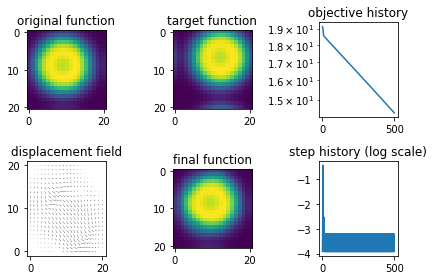

In [330]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
(ux,uy)=u
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(lib.interpol(f,u))
ax[1,1].set_title('final function')
ax[0,2].semilogy(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $(P)\quad\min_u E(u)+R(u)$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad\mbox{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

Q6. Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.

Q7. Implémenter une classe `MoindreCarres` qui prend en argument à l'initialisation les fonctions `E` et `R`. A l'initialisation, elle crée une instance de la classe `objectif` qu'elle met dans la variable `self.obj`. Ainsi on peut retrouver la fonction coût en appelant la fonction `self.obj.eval()`.
Cette classe doit comporter les fonctions `compute(u)`, `JPsi(u,h)`,`JPsiT(u,phi)`,`LM(u,h,epsilon)` qui calculent respectivement

- Le vecteur $\Psi(u)$
- le produit de $J_\psi(u)$ par une direction $h=(h_x,h_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $h=(h_x,h_y)\in V^2$.

Ensuite on teste nos fonctions avec les différents tests ci-dessous.

In [331]:
# definition des produits scalaires

def prod_image(im1,im2) :
    return np.dot(im1.ravel(),im2.ravel())
def produit1(u,v) :
    (ux,uy)=u
    (vx,vy)=v
    return prod_image(ux,vx)+prod_image(uy,vy)
def produit2(psi,phi) :
    (psi1,psi2,psi3)=psi
    (phi1,phi2,phi3)=phi
    return prod_image(psi1,phi1)+prod_image(psi2,phi2)+prod_image(psi3,phi3)

# CREATION DES PROBLEMES
r=lib.R(lam=10,mu=0)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
np.random.seed(42)
u=(np.random.randn(nx,ny),np.random.randn(nx,ny))
tmp=MC.compute(u)
print(MC.obj.eval(u),0.5*produit2(tmp,tmp)) # Vous devez trouver 8741.724838697675

# TEST de la transposée de la jacobienne de J
h=(np.random.randn(nx,ny),np.random.randn(nx,ny))
psi=(np.random.randn(nx,ny),np.random.randn(nx,ny),np.random.randn(nx,ny))
psi1=MC.JPsi(u,h)
h1=MC.JPsiT(u,psi)
print(produit1(h,h1),produit2(psi,psi1)) # Vous devez trouver -8.42128630007934

# test de la matrice 
r=MC.LM(u,h,epsilon=1.e3)
print(produit1(r,h)) #Vous devez trouver 900512.3254249494

8741.724838697675 8741.724838697675
-8.421286300079373 -8.42128630007934
900512.3254249494


Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u)^\top J_\Psi(u) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [332]:
def CGSolve(u,b,epsilon,MC) :
    nitmax=100;
    r=(b[0],b[1])
    d=(np.zeros_like(r[0]),np.zeros_like(r[1]))
    p=(np.copy(r[0]),np.copy(r[1]))
    
    rsold=produit1(r,r)
    for i in range(nitmax) :
        Ap=MC.LM(u,p,epsilon=epsilon)
        alpha=rsold/produit1(r,Ap)
        d=(d[0]+alpha*p[0],d[1]+alpha*p[1])
        r=(r[0]-alpha*Ap[0],r[1]-alpha*Ap[1])
        rsnew=produit1(r,r)
        if np.sqrt(rsnew)<1e-10 :
            return x
        p=(r[0]+rsnew/rsold*p[0],r[1]+rsnew/rsold*p[1])
        rsold=rsnew
    return d

Q8. Compléter l'algorithme `RecalageGN` implémentant la méthode de Levenberg-Marquardt. C'est essentiellement l'algorithme de gradient à pas fixe, sauf qu'on choisit une direction de descente différente.

Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [334]:
epsi=0.1
nitermax=1000
u,CF,step=RecalageGN(MC,nitermax,epsi)

iteration 3 cost 1.838e+00 step 8.00000e-01
iteration 6 cost 8.563e-01 step 1.60000e+00
iteration 9 cost 5.218e-01 step 1.60000e+00
iteration 12 cost 3.781e-01 step 8.00000e-01
iteration 15 cost 3.721e-01 step 1.60000e+00
iteration 18 cost 3.655e-01 step 8.00000e-01


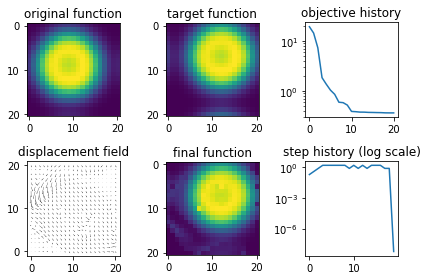

In [316]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
(ux,uy)=u
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(lib.interpol(f,u))
ax[1,1].set_title('final function')
ax[0,2].semilogy(CF)
ax[0,2].set_title('objective history')
ax[1,2].semilogy(step)
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()